# Understanding personal protective behaviours and opportunities for interventions:
## Results from a multi-method investigation of cross-sectional data
#### Kaisa Sauro, James Twose, Gjalt-Jorn Peters, Matti Heino & Nelli Hankonen

## approaches used here: _PCIs_, _Linear Regression_, _Correlations_

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats


In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.model_selection import KFold

In [5]:
import statsmodels.api as sm

In [6]:
from jmspack.frequentist_statistics import (correlation_analysis,
                                            potential_for_change_index,
                                            multiple_univariate_OLSs
                                           )
from jmspack.utils import (flatten,
                           apply_scaling,
                           JmsColors
                          )

In [7]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

# _ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [8]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [9]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [10]:
df.head()

,id,sampling_weight,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,demographic_higher_education,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,...,intention_public_transport_recoded,intention_indoor_meeting_recoded,intention_restaurant_recoded,intention_pa_recoded,intention_composite,behaviour_indoors_nonhouseholders_recoded,behaviour_unmasked_recoded,behavior_composite,behavior_composite_recoded,intention_behavior_composite
0,1,2.060959,2,60+,2,7,0,2,5,2,...,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.784139,2,40-49,1,1,1,3,3,2,...,0,1,1,1,3,0.785714,0.214286,0.168367,0.841837,1.920918
2,3,1.204000,1,60+,1,2,1,4,4,2,...,0,0,0,0,0,0.500000,0.214286,0.107143,0.535714,0.267857
3,4,2.232220,1,60+,2,6,0,4,3,2,...,0,2,0,2,4,0.500000,0.500000,0.250000,1.250000,2.625000
4,5,1.627940,2,18-29,1,3,0,6,3,2,...,0,2,0,0,2,0.000000,0.214286,0.000000,0.000000,1.000000


In [11]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [12]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [13]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [14]:
target = "intention_behavior_composite"

In [15]:
df[target] = (df[target] - 10) * -1

In [16]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

In [17]:
meta_columns = ['Original position', 'Variable name', 'Label',
       'Item english translation', 'Label short', 'Type', 'New variable name',
       'variable name helper',
       'Of primary interest as a predictor (i.e. feature)?', 'English lo-anchor',
       'English hi-anchor']

In [18]:
meta_df = pd.read_excel("metadata/questionLabels.xlsx").loc[:, meta_columns]

In [19]:
meta_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective|^behaviour|^intention").columns.tolist()

In [20]:
pd.set_option("display.max_colwidth", 350)
pd.set_option('display.expand_frame_repr', True)
meta_df.loc[meta_df["New variable name"].isin(meta_list), ["Item english translation", "New variable name"]]

,Item english translation,New variable name
12,"How often in the last 7 days have you been indoors with people outside your household so that it is not related to obligations? For example, meeting friends, visiting hobbies, non-essential shopping, or other activities that are not required for your work or other duties.",behaviour_indoors_nonhouseholders
13,"In the last 7 days, have you been in close contact with people outside your household? Direct contact means spending more than one minute less than two meters away from another person or touching (e.g., shaking hands) outdoors or indoors.",behaviour_close_contact
14,"Are you currently in quarantine or isolation due to an official instruction or order? (For example, because you are waiting for a corona test, have returned from abroad or been exposed to a coronavirus)",behaviour_quarantined
15,How often in the last 7 days were you in your free time without a mask indoors with people you don’t live with?,behaviour_unmasked
24,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Grocery store or other store",intention_store
25,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Bus, train or other means of public transport",intention_public_transport
26,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Meeting people outside your household indoors",intention_indoor_meeting
27,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Cafe, restaurant or bar indoors",intention_restaurant
28,"If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Indoor exercise",intention_pa
29,"Taking a mask with you to a store or public transport, for example, has already become automatic for some and is done without thinking. For others, taking a mask with them is not automatic at all, but requires conscious thinking and effort.",automaticity_carry_mask


In [21]:
pd.set_option("display.max_colwidth", 100)

## EDA on the target
Check the amount of samples in the target

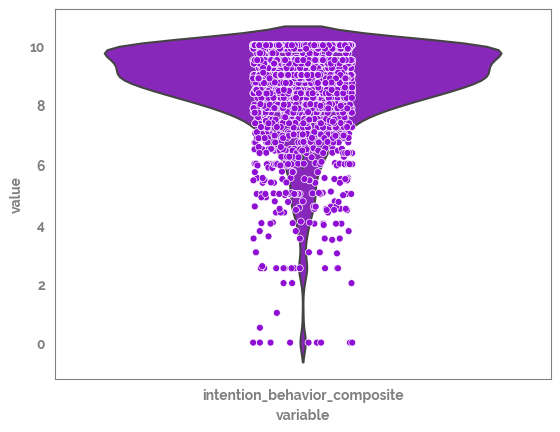

In [22]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [23]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age,18-29,30-39,40-49,50-59,60+
demographic_gender,,,,,
1,114,169,187,168,337
2,281,185,229,211,391


In [24]:
target_df = df[target]
target_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
intention_behavior_composite,2272.0,8.582428,1.524704,-0.0,8.017857,8.964286,9.5,10.0


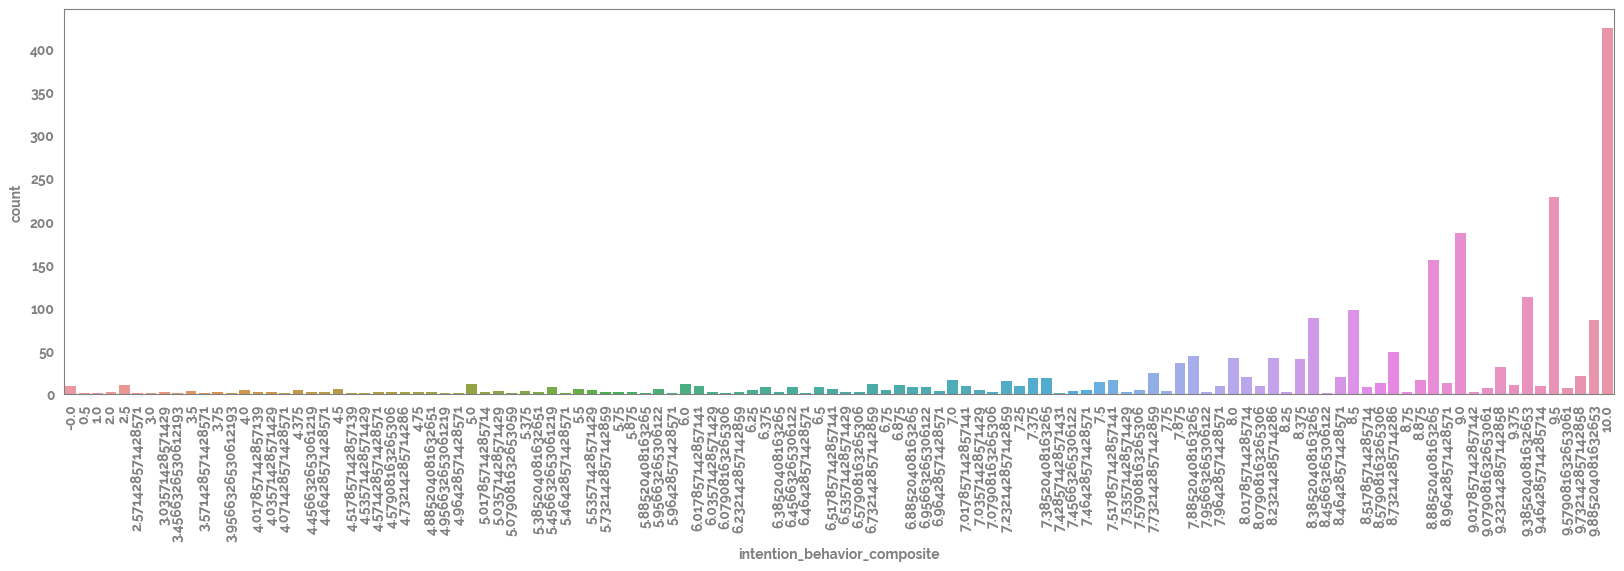

In [25]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

In [26]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   demographic_age                   2272 non-null   object 
 1   demographic_higher_education      2272 non-null   int64  
 2   automaticity_carry_mask           2272 non-null   int64  
 3   automaticity_put_on_mask          2272 non-null   int64  
 4   inst_attitude_protects_self       2272 non-null   int64  
 5   inst_attitude_protects_others     2272 non-null   int64  
 6   inst_attitude_sense_of_community  2272 non-null   int64  
 7   inst_attitude_enough_oxygen       2272 non-null   int64  
 8   inst_attitude_no_needless_waste   2272 non-null   int64  
 9   norms_family_friends              2272 non-null   int64  
 10  norms_risk_groups                 2272 non-null   int64  
 11  norms_officials                   2272 non-null   int64  
 12  norms_

In [28]:
display(df[target].value_counts().head().to_frame()), df.shape[0], df[target].value_counts().head().sum()

,intention_behavior_composite
10.000000,424
9.500000,228
9.000000,187
8.885204,155
9.385204,112


(None, 2272, 1106)

## Correlations between features and target

In [29]:
dict_results = correlation_analysis(df, 
                                    row_list=[target],
                                    col_list=features_list,
                                    # method='pearson', 
                                    check_norm=True,
                                    dropna='pairwise')

In [30]:
corrs_df = dict_results["summary"].sort_values(by="r-value", ascending=False)
corrs_df.head(5)

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
10,Spearman Rank,norms_people_present_indoors,intention_behavior_composite,0.417490,1.573553e-96,True,2272
17,Spearman Rank,effective_means_masks,intention_behavior_composite,0.398325,2.909620e-87,True,2272
0,Spearman Rank,automaticity_carry_mask,intention_behavior_composite,0.373645,3.383126e-76,True,2272
22,Spearman Rank,risk_severity,intention_behavior_composite,0.367338,1.609304e-73,True,2272
7,Spearman Rank,norms_family_friends,intention_behavior_composite,0.365861,6.684440e-73,True,2272


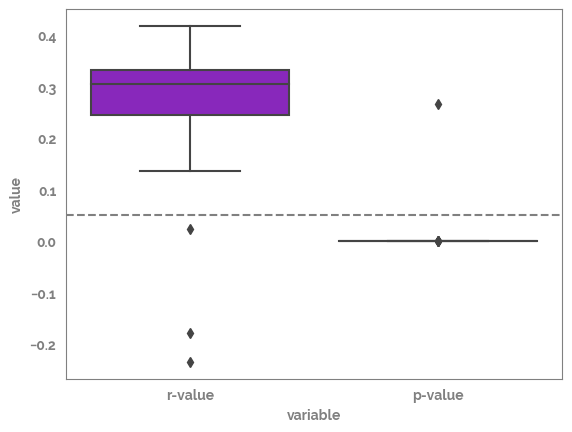

In [31]:
_ = sns.boxplot(data=corrs_df[["r-value", "p-value"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [32]:
neg_corrs_features = corrs_df[corrs_df["r-value"] < 0].feature1.tolist()

In [33]:
neg_corrs_features

['aff_attitude_difficult_breathing', 'risk_fear_restrictions']

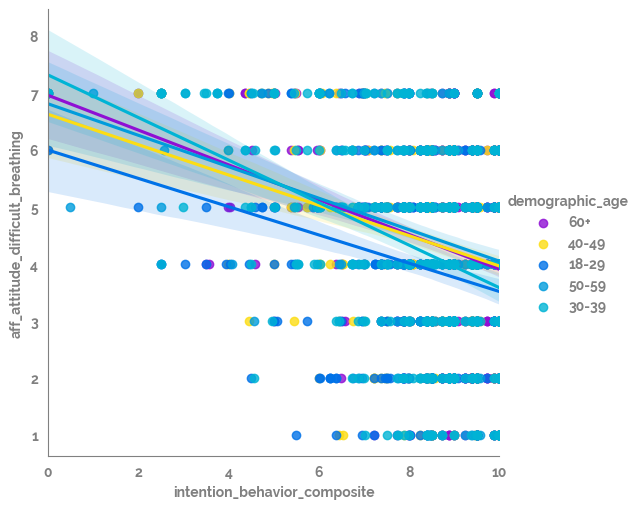

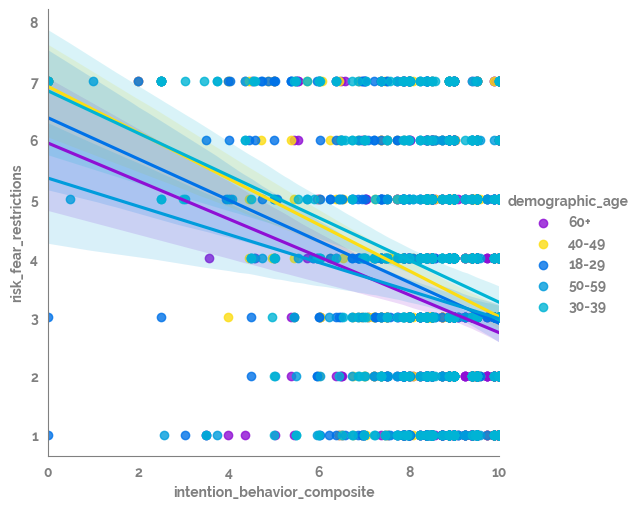

In [34]:
for feature in neg_corrs_features:
    _ = sns.lmplot(data=df, 
               x=target, 
               y=feature, 
               hue="demographic_age",
              legend=True)

## Multivariate Linear Regression

In [35]:
X = df[features_list]
y = df[target]

In [36]:
mod = sm.OLS(endog=y, exog=X)
res = mod.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4050.
Date:                          Sat, 11 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  19:03:49   Log-Likelihood:                         -3705.8
No. Observations:                          2272   AIC:                                      7466.
Df Residuals:                              2245   BIC:                                      7620.
Df Model:                                    27                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0923      0.031      2.933      0.003       0.031       0.154
automaticity_put_on_mask             0.0787      0.034      2.331      0.020       0.012       0.145
inst_attitude_protects_self         -0.0120      0.024     -0.491      0.624      -0.060       0.036
inst_attitude_protects_others        0.2237      0.032      6.901      0.000       0.160       0.287
inst_attitude_sense_of_community    -0.0035      0.020     -0.173      0.863      -0.043       0.036
inst_attitude_enough_oxygen          0.1177      0.021      5.668      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0190      0.016      1.172      0.241      -0.013       0.051
norms_family_friends                 0.0758      0.027      2.840      0.005       0.023       0.128
norms_risk_groups                -4.061e-05      0.034     -0.001      0.999      -0.067       0.067
norms_officials                      0.1520      0.032      4.817      0.000       0.090       0.214
norms_people_present_indoors         0.1691      0.024      7.160      0.000       0.123       0.215
aff_attitude_comfortable             0.0224      0.029      0.778      0.437      -0.034       0.079
aff_attitude_calm                    0.0316      0.027      1.192      0.233      -0.020       0.084
aff_attitude_safe                    0.0213      0.031      0.688      0.492      -0.039       0.082
aff_attitude_responsible             0.0120      0.033      0.363      0.717      -0.053       0.077
aff_attitude_difficult_breathing     0.1773      0.019      9.375      0.000       0.140       0.214
effective_means_handwashing          0.0465      0.021      2.170      0.030       0.004       0.089
effective_means_masks                0.0202      0.028      0.721      0.471      -0.035       0.075
effective_means_distance             0.1063      0.026      4.127      0.000       0.056       0.157
effective_means_ventilation          0.0497      0.020      2.507      0.012       0.011       0.089
risk_likely_contagion                0.0551      0.023      2.344      0.019       0.009       0.101
risk_contagion_absent_protection     0.0012      0.020      0.062      0.951      -0.038       0.040
risk_severity                        0.1452      0.021      6.893      0.000       0.104       0.187
risk_fear_spread                     0.0224      0.026      0.848      0.396      -0.029       0.074
risk_fear_contagion_self            -0.0313      0.026     -1.206      0.228      -0.082       0.020
risk_fear_contagion_others          -0.0046   

## Multiple univariate regressions

In [37]:
all_coefs_df = multiple_univariate_OLSs(X=X, y=y, features_list=features_list)

In [38]:
all_coefs_df.sort_values("rsquared_adj", ascending=False)

,coef,std err,t,P>|t|,[0.025,0.975],rsquared,rsquared_adj
automaticity_put_on_mask,0.4652,0.016,29.656,0.0,0.434,0.496,0.279246,0.278928
automaticity_carry_mask,0.4463,0.015,29.076,0.0,0.416,0.476,0.271358,0.271037
effective_means_masks,0.4922,0.017,28.986,0.0,0.459,0.526,0.270137,0.269816
inst_attitude_protects_others,0.5895,0.023,25.875,0.0,0.545,0.634,0.227764,0.227423
norms_people_present_indoors,0.4811,0.019,25.760,0.0,0.444,0.518,0.226196,0.225855
norms_family_friends,0.4673,0.018,25.590,0.0,0.431,0.503,0.223887,0.223545
aff_attitude_responsible,0.5329,0.022,24.703,0.0,0.491,0.575,0.211873,0.211526
aff_attitude_safe,0.4776,0.022,21.636,0.0,0.434,0.521,0.170959,0.170593
norms_risk_groups,0.4905,0.024,20.656,0.0,0.444,0.537,0.158217,0.157847
risk_severity,0.3424,0.017,20.105,0.0,0.309,0.376,0.151148,0.150774


In [39]:
top_feature = all_coefs_df.sort_values("rsquared_adj").tail(1).iloc[0].name

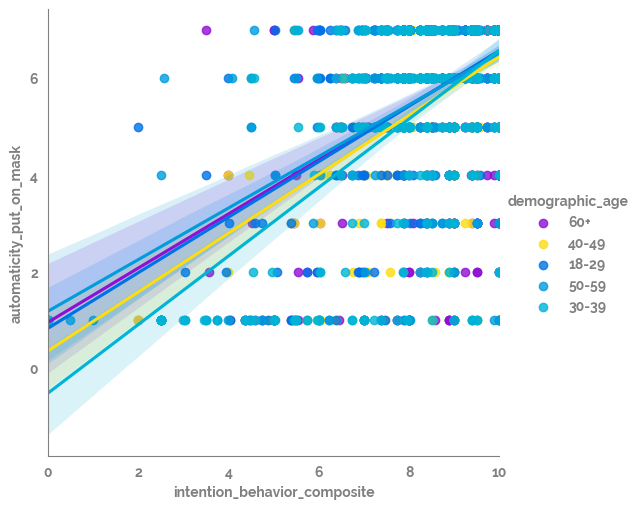

In [40]:
_ = sns.lmplot(data=df, 
               x=target, 
               y=top_feature, 
               hue="demographic_age",
              legend=True)

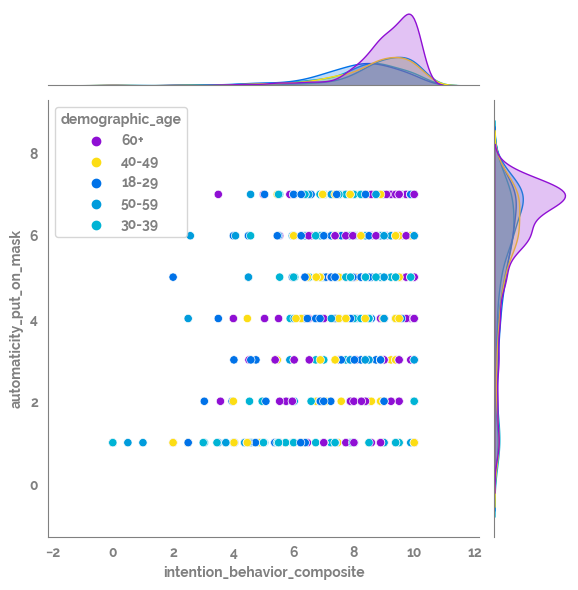

In [41]:
ax = sns.jointplot(data=df, 
                  x=target, 
                  y=top_feature, 
                  hue="demographic_age",
                  # kind="reg",
                   legend=True
                 )

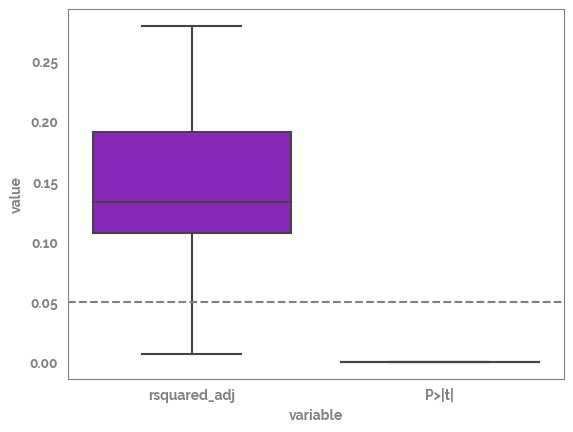

In [42]:
_ = sns.boxplot(data=all_coefs_df[["rsquared_adj", "P>|t|"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [43]:
mod = sm.OLS(endog=y, exog=X[[top_feature]])
res = mod.fit()

In [44]:
y_pred = res.predict(exog = X[[top_feature]])

df_test = pd.DataFrame({"y_pred": y_pred, target: y})

user_ids_first = df_test.head(1).index.tolist()[0]
user_ids_last = df_test.tail(1).index.tolist()[0]

plot_title="All"

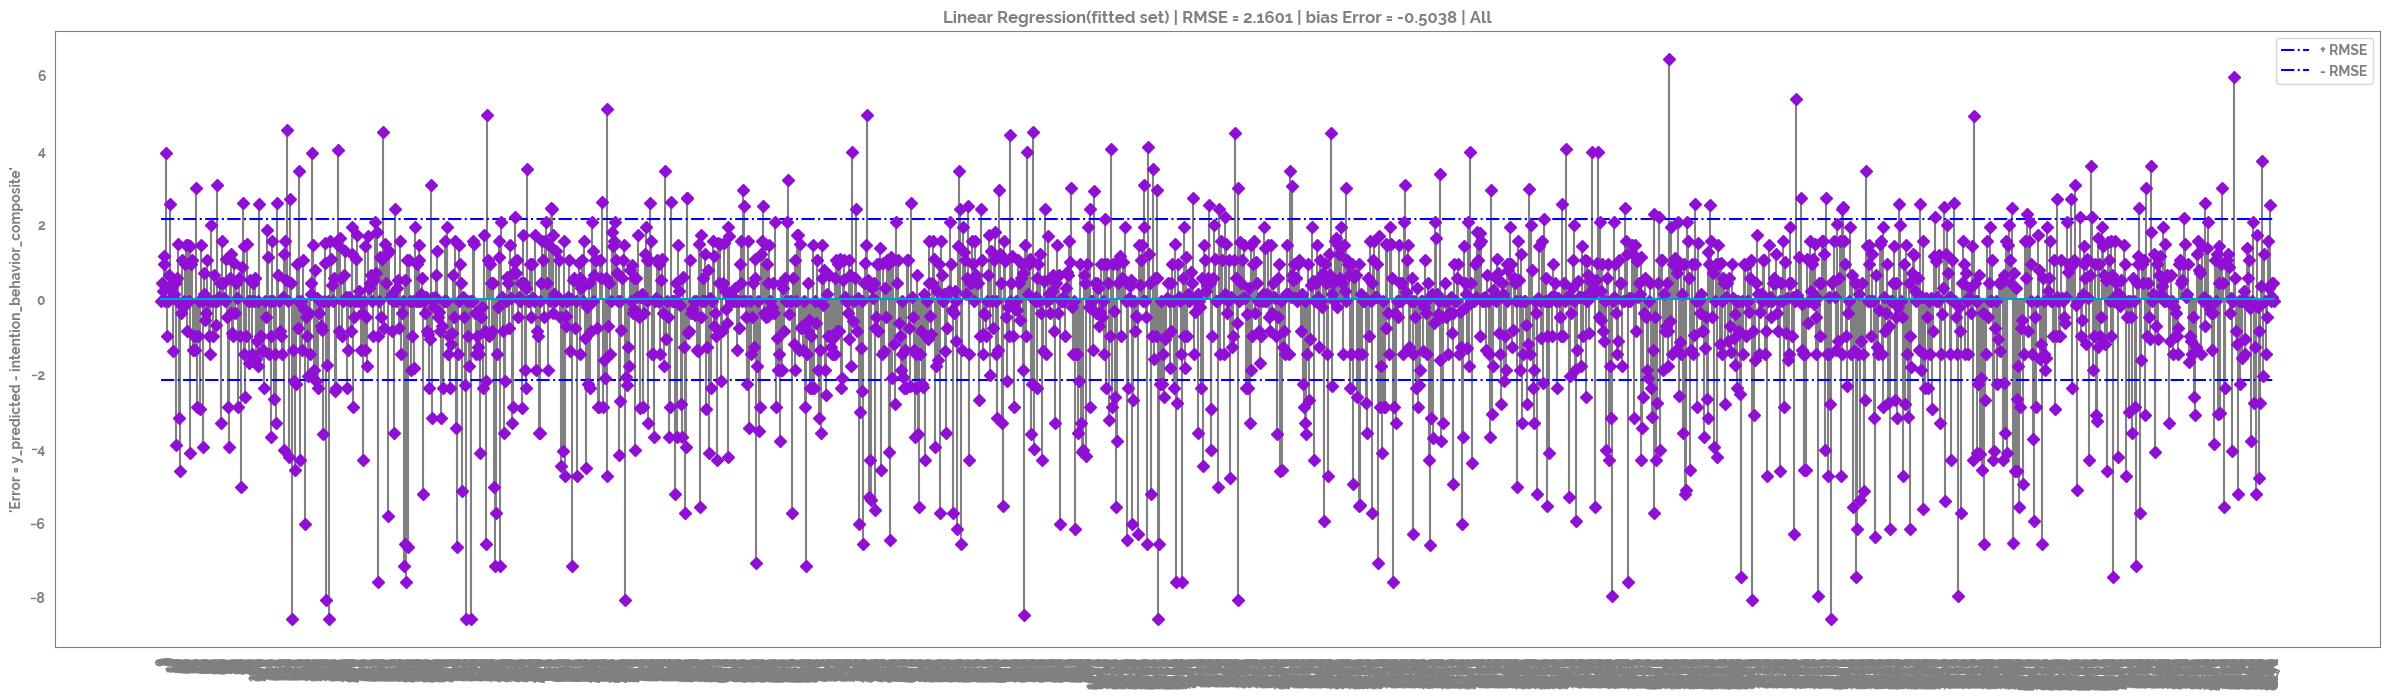

In [45]:
_ = plt.figure(figsize=(30,8))
_ = plt.title(f"Linear Regression(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[target]), 4)} | {plot_title}")
rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
_ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', 
               xmin = user_ids_first, 
               xmax = user_ids_last
              ) 
_ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', 
               xmin = user_ids_first, 
               xmax = user_ids_last
              ) 
_ = plt.xticks(rotation=90, ticks=df_test.index)
_ = plt.ylabel(f"'Error = y_predicted - {target}'")
_ = plt.legend()
_ = plt.show()

In [46]:
groups_dict = {"18 - 39": ['18-29','30-39'],
              "40 - 59": ['40-49', '50-59'],
              "60+": ['60+'],
              "All": ['60+', '40-49', '18-29', '50-59', '30-39'],
              "Lower Education": 0,
              "Higher Education": 1}

In [47]:
all_ols_df = pd.DataFrame()
for group in groups_dict:
    if type(groups_dict[group]) == list:
        tmp_df = df[df["demographic_age"].isin(groups_dict[group])]
    else:
        tmp_df = df[df["demographic_higher_education"] == groups_dict[group]]
        
    tmp_X = tmp_df[features_list]
    tmp_y = tmp_df[target]

    tmp_ols_df = multiple_univariate_OLSs(X=tmp_X, 
                                          y=tmp_y, 
                                          features_list=features_list)[["coef", "P>|t|", "rsquared_adj"]]
    tmp_ols_df.columns = pd.MultiIndex.from_tuples([(group, x) for x in tmp_ols_df.columns.tolist()])
    all_ols_df = pd.concat([all_ols_df, tmp_ols_df], axis=1)

In [48]:
all_ols_df

18 - 39                     40 - 59         \
                                    coef  P>|t| rsquared_adj    coef  P>|t|   
automaticity_carry_mask           0.4454  0.000     0.270860  0.4344  0.000   
automaticity_put_on_mask          0.4799  0.000     0.300845  0.4705  0.000   
inst_attitude_protects_self       0.3929  0.000     0.121830  0.4209  0.000   
inst_attitude_protects_others     0.6651  0.000     0.282943  0.5869  0.000   
inst_attitude_sense_of_community  0.3587  0.000     0.118604  0.3489  0.000   
inst_attitude_enough_oxygen       0.2922  0.000     0.122269  0.2974  0.000   
inst_attitude_no_needless_waste   0.3388  0.000     0.143568  0.2405  0.000   
norms_family_friends              0.4971  0.000     0.232984  0.4680  0.000   
norms_risk_groups                 0.4319  0.000     0.127284  0.4867  0.000   
norms_officials                   0.4811  0.000     0.097753  0.4472  0.000   
norms_people_present_indoors      0.4411  0.000     0.183380  0.4679  0.000   
aff_attitude_comfortable          0.3836  0.000     0.129391  0.4373  0.000   
aff_attitude_calm                 0.3956  0.000     0.155858  0.3652  0.000   
aff_attitude_safe                 0.5253  0.000     0.175998  0.4790  0.000   
aff_attitude_responsible          0.5683  0.000     0.221201  0.5268  0.000   
aff_attitude_difficult_breathing -0.2890  0.000     0.084542 -0.2775  0.000   
effective_means_handwashing       0.1223  0.003     0.010712  0.2206  0.000   
effective_means_masks             0.4607  0.000     0.243742  0.5072  0.000   
effective_means_distance          0.3681  0.000     0.122005  0.3559  0.000   
effective_means_ventilation       0.2187  0.000     0.038280  0.2245  0.000   
risk_likely_contagion             0.2217  0.000     0.025561  0.1058  0.014   
risk_contagion_absent_protection  0.3651  0.000     0.147379  0.3077  0.000   
risk_severity                     0.3577  0.000     0.110056  0.2932  0.000   
risk_fear_spread                  0.3703  0.000     0.165041  0.3513  0.000   
risk_fear_contagion_self          0.2942  0.000     0.115572  0.3128  0.000   
risk_fear_contagion_others        0.3810  0.000     0.153481  0.3669  0.000   
risk_fear_restrictions           -0.2346  0.000     0.079227 -0.2402  0.000   

                                                  60+                      \
                                 rsquared_adj    coef  P>|t| rsquared_adj   
automaticity_carry_mask              0.241427  0.3524  0.000     0.209231   
automaticity_put_on_mask             0.270563  0.3359  0.000     0.187063   
inst_attitude_protects_self          0.154815  0.2454  0.000     0.083291   
inst_attitude_protects_others        0.220588  0.4312  0.000     0.171396   
inst_attitude_sense_of_community     0.124954  0.2154  0.000     0.085699   
inst_attitude_enough_oxygen          0.129374  0.1746  0.000     0.079068   
inst_attitude_no_needless_waste      0.088683  0.1493  0.000     0.060426   
norms_family_friends                 0.229955  0.3533  0.000     0.177433   
norms_risk_groups                    0.160871  0.4841  0.000     0.173283   
norms_officials                      0.099572  0.4771  0.000     0.178767   
norms_people_present_indoors         0.214813  0.4305  0.000     0.218075   
aff_attitude_comfortable             0.160466  0.2504  0.000     0.100396   
aff_attitude_calm                    0.147922  0.2252  0.000     0.103092   
aff_attitude_safe                    0.158149  0.3195  0.000     0.124132   
aff_attitude_responsible             0.192626  0.3924  0.000     0.174434   
aff_attitude_difficult_breathing     0.073396 -0.1599  0.000     0.047479   
effective_means_handwashing          0.034616  0.2348  0.000     0.054795   
effective_means_masks                0.253820  0.3930  0.000     0.205402   
effective_means_distance             0.098371  0.3042  0.000     0.068855   
effective_means_ventilation          0.049446  0.1737  0.000     0.044676   
risk_likely_contagion                0.006315  

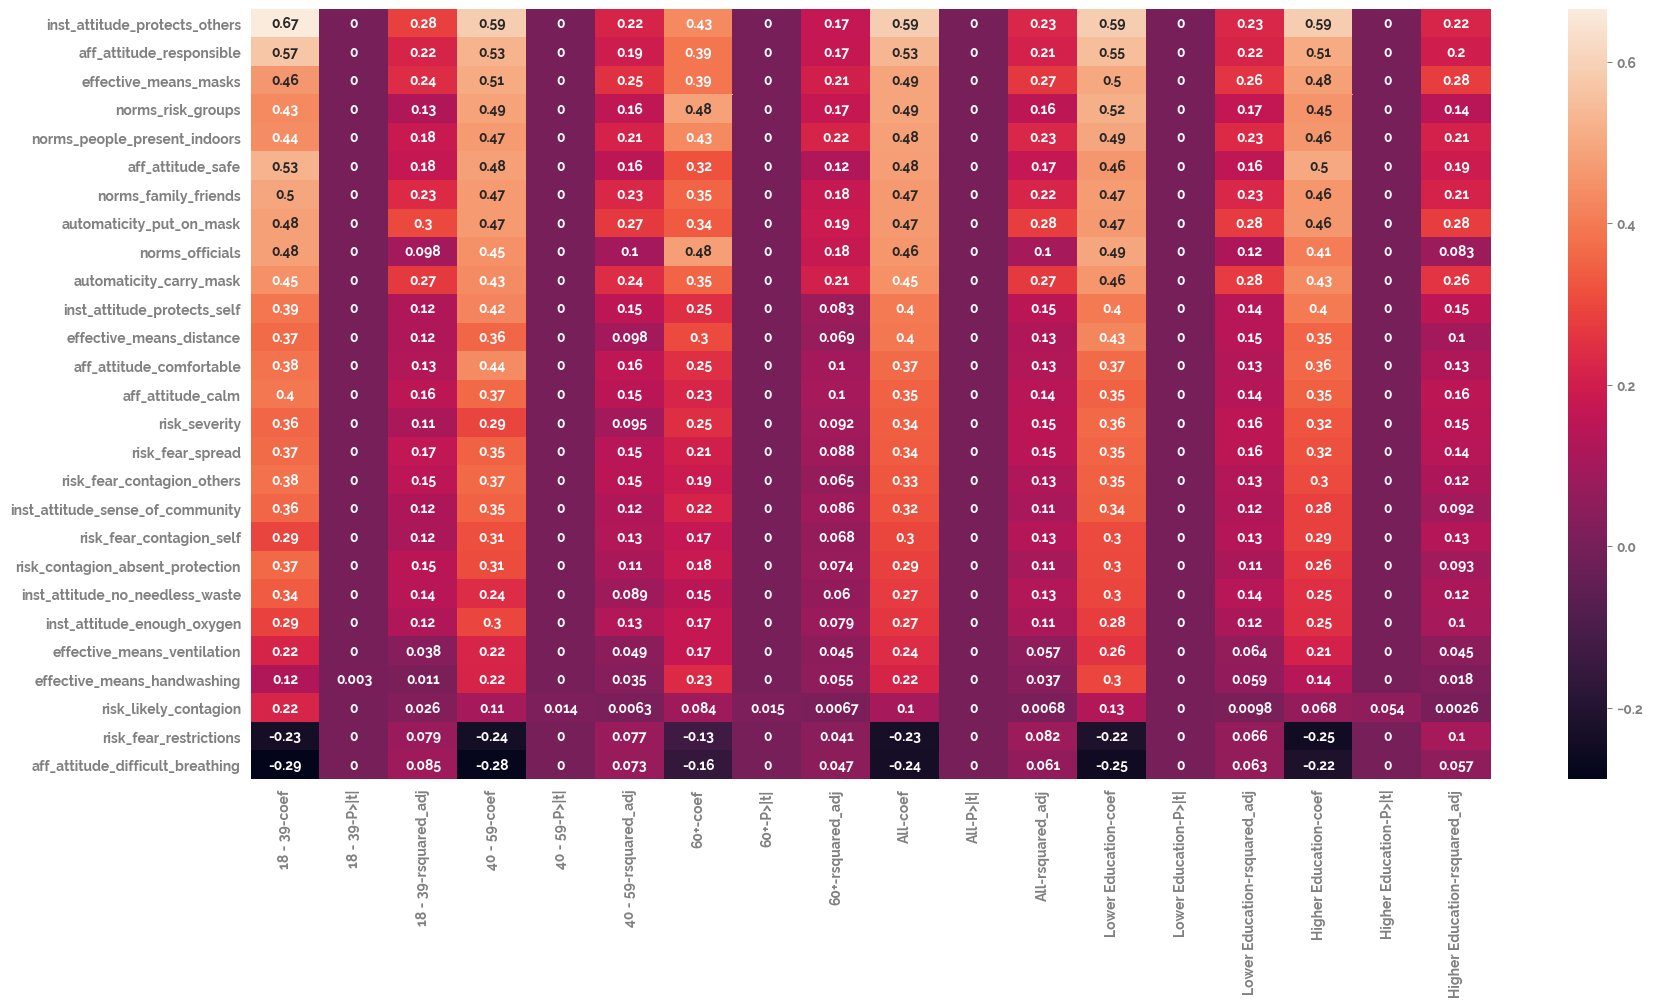

In [49]:
_ = plt.figure(figsize=(20,10))
_ = sns.heatmap(data=all_ols_df.sort_values(by = ("All", "coef"), ascending=False),
               annot=True)
_ = plt.xlabel("")

In [50]:
bootstrap_sample_size = 1000
bootstrap_number = 100

In [51]:
all_pcis_df = pd.DataFrame()
for i in range(0, bootstrap_number):
    tmp_pci_df = potential_for_change_index(data=df
                                            .sample(n=bootstrap_sample_size, random_state=0 + i)
                                            .drop(["demographic_age", "demographic_higher_education"], axis=1),
                                           features_list=features_list,
                                            target=target,
                                            minimum_measure = 'min',
                                            centrality_measure = 'mean',
                                            maximum_measure = 'max',
                                            weight_measure = 'r-value',
                                            scale_data = False,
                                            pci_heatmap = False,)
    all_pcis_df = pd.concat([all_pcis_df, tmp_pci_df["PCI"]], axis=1)

In [52]:
all_pcis_df.columns = [f"PCI_{x}" for x in range(0, all_pcis_df.shape[1])]

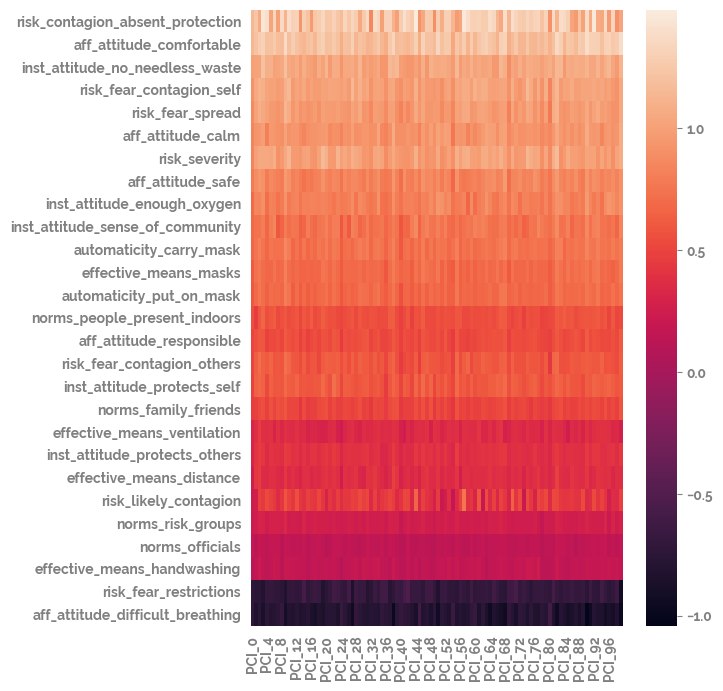

In [53]:
_ = plt.figure(figsize=(6, 8))
_ = sns.heatmap(all_pcis_df.sort_values(by="PCI_0", ascending=False))

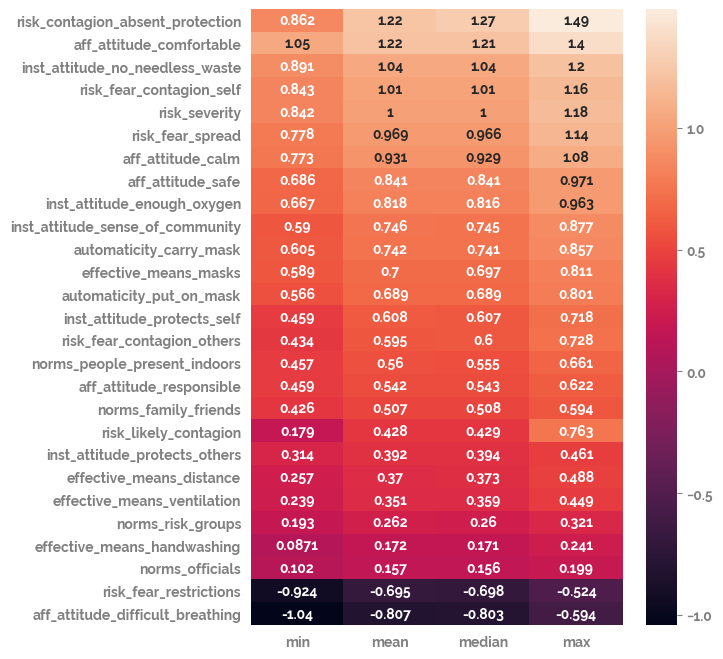

In [54]:
_ = plt.figure(figsize=(6, 8))
_ = sns.heatmap(all_pcis_df.agg(["min", "mean", "median", "max"], axis=1).sort_values(by="mean", ascending=False),
               annot=True,
               fmt=".3g")

In [55]:
all_pcis_df = pd.DataFrame()
for group in groups_dict:
    if type(groups_dict[group]) == list:
        tmp_df = df[df["demographic_age"].isin(groups_dict[group])]
    else:
        tmp_df = df[df["demographic_higher_education"] == groups_dict[group]]

    tmp_pci_df = potential_for_change_index(data=tmp_df.drop(["demographic_age", "demographic_higher_education"], axis=1),
                                           features_list=features_list,
                                            target=target,
                                            minimum_measure = 'min',
                                            centrality_measure = 'mean',
                                            maximum_measure = 'max',
                                            weight_measure = 'r-value',
                                            scale_data = True,
                                            pci_heatmap = False,)
    tmp_pci_df = tmp_pci_df.rename(columns={"PCI": f"PCI_{group}"})
    all_pcis_df = pd.concat([all_pcis_df, tmp_pci_df[f"PCI_{group}"]], axis=1)

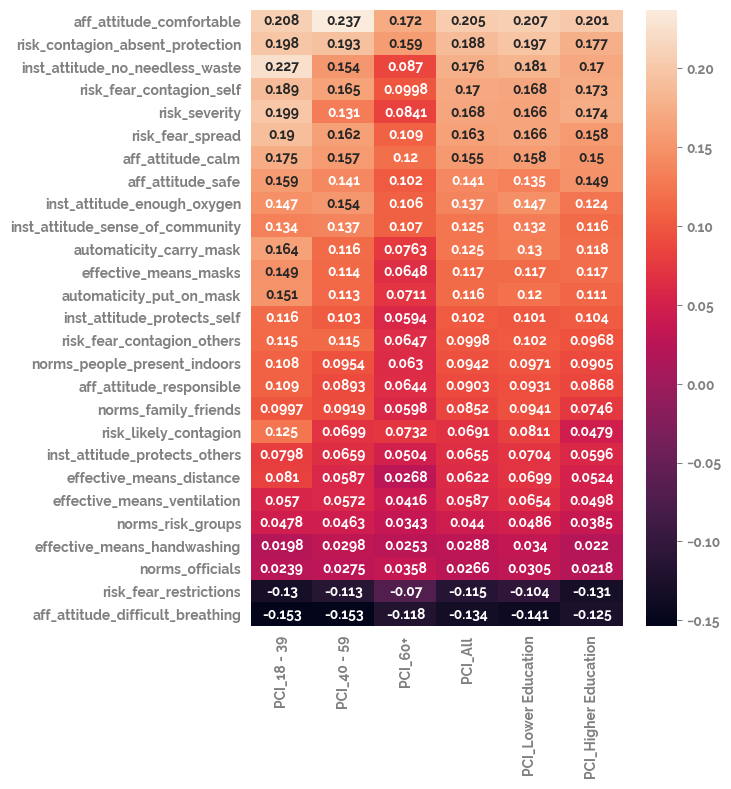

In [56]:
_ = plt.figure(figsize=(6, 8))
_ = sns.heatmap(all_pcis_df.sort_values(by="PCI_All", ascending=False),
               annot=True,
                fmt=".3g"
               )

In [57]:
all_group_pci_df = potential_for_change_index(data=df.drop(["demographic_age", "demographic_higher_education"], axis=1),
                                           features_list=features_list,
                                            target=target,
                                            minimum_measure = 'min',
                                            centrality_measure = 'mean',
                                            maximum_measure = 'max',
                                            weight_measure = 'r-value',
                                            scale_data = True,
                                            pci_heatmap = False,)
all_group_pci_df = all_group_pci_df.rename(columns={"PCI": "PCI_All"})

In [58]:
meta_df.columns

Index(['Original position', 'Variable name', 'Label',
       'Item english translation', 'Label short', 'Type', 'New variable name',
       'variable name helper',
       'Of primary interest as a predictor (i.e. feature)?',
       'English lo-anchor', 'English hi-anchor'],
      dtype='object')

In [59]:
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 0)
all_group_pci_df_new=(pd.merge(all_group_pci_df, 
         meta_df.loc[meta_df["New variable name"].isin(features_list), ["Item english translation", "New variable name", 'English lo-anchor', 'English hi-anchor']],
         left_index=True,
         right_on="New variable name")
 .set_index(["Item english translation", "New variable name", 'English lo-anchor', 'English hi-anchor'])
#  .drop("New variable name", axis=1)
)

In [60]:
pd.set_option("precision", 3)
(all_group_pci_df_new
 .sort_values(by="PCI_All", ascending=False)
 .round(3)
 .style.bar(subset=['PCI_All', 'mean', "r-value"], 
            align='mid', 
            color=['#d65f5f', '#5fba7d'])
)

In [61]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
(all_group_pci_df_new
 .sort_values(by="PCI_All", ascending=False)
#  .round(3)
 .style.background_gradient(cmap, 
                            subset=['PCI_All'], 
                            axis=1, 
                            vmin=-0.15, 
                            vmax=0.25)
)